
Congrats....again! Based off the amazing work you did on the classification model, you've been promoted to chief of all data scientists in Hollywood, your a total celebrity....among data scientists :).  

Your boss, head of the studio, has now asked you to build a model to predict gross revenue in order to help them decide which movies to invest in.

Once again, you would like to be able to explain the model to mere mortals but need a fairly robust and flexible approach so you've chosen to use decision trees to get started. 

In doing so...you leverage work you've done in the past to get the job done....you're a data scientist after all! 

In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [39]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [88]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz 
from sklearn.model_selection import train_test_split     # for splitting data
from sklearn.model_selection import KFold                # for cross-validation
from sklearn.model_selection import GridSearchCV     
from sklearn.tree import DecisionTreeClassifier  
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import export_graphviz 
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [92]:
#1. Load the data
#Sometimes need to set the working directory back out of a folder that we create a file in
import os
print(os.getcwd())
movie_metadata = pd.read_csv("../data/movie_metadata.csv")
print(movie_metadata.head())
print(movie_metadata['movie_title'])


/Users/anayanath/rainbow/DS-3021-analytics-1/09_DT_Regression
   color      director_name  num_critic_for_reviews  duration  \
0  Color      James Cameron                   723.0     178.0   
1  Color     Gore Verbinski                   302.0     169.0   
2  Color         Sam Mendes                   602.0     148.0   
3  Color  Christopher Nolan                   813.0     164.0   
4    NaN        Doug Walker                     NaN       NaN   

   director_facebook_likes  actor_3_facebook_likes      actor_2_name  \
0                      0.0                   855.0  Joel David Moore   
1                    563.0                  1000.0     Orlando Bloom   
2                      0.0                   161.0      Rory Kinnear   
3                  22000.0                 23000.0    Christian Bale   
4                    131.0                     NaN        Rob Walker   

   actor_1_facebook_likes        gross                           genres  ...  \
0                  1000.0  7605058

#2 Ensure all the variables are classified correctly and collapse factor variables as needed.

In [40]:
# Start with a fresh copy of your cleaned data
movie_metadata_encoded = movie_metadata.copy()

# One-hot encode low-cardinality categorical columns
categorical_cols = ['color', 'language', 'country', 'content_rating']
movie_metadata_encoded = pd.get_dummies(movie_metadata_encoded, columns=categorical_cols, drop_first=True)

#Frequency encode high-cardinality columns
high_cardinality_cols = ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']
for col in high_cardinality_cols:
    freq = movie_metadata_encoded[col].value_counts()
    movie_metadata_encoded[col] = movie_metadata_encoded[col].map(freq)

#One-hot encode multi-genre column
movie_metadata_encoded['genres'] = movie_metadata_encoded['genres'].str.split('|')
genres_dummies = movie_metadata_encoded['genres'].str.join('|').str.get_dummies(sep='|')
movie_metadata_encoded = pd.concat([movie_metadata_encoded, genres_dummies], axis=1)
movie_metadata_encoded.drop('genres', axis=1, inplace=True)

bool_cols = movie_metadata_encoded.select_dtypes(include='bool').columns
movie_metadata_encoded[bool_cols] = movie_metadata_encoded[bool_cols].astype(int)

#Check data types to confirm all numeric
print(movie_metadata_encoded.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Columns: 174 entries, director_name to Western
dtypes: float64(14), int64(160)
memory usage: 6.7 MB
None


#3 Check for missing variables and correct as needed.

In [42]:
# Check if any missing values exist
print(movie_metadata_encoded.isnull().values.any())

# Count missing values per column
print(movie_metadata_encoded.isnull().sum())


False
director_name              0
num_critic_for_reviews     0
duration                   0
director_facebook_likes    0
actor_3_facebook_likes     0
                          ..
Short                      0
Sport                      0
Thriller                   0
War                        0
Western                    0
Length: 174, dtype: int64


#4 Guess what, you don't need to scale the data, because DTs don't require this to be done, they make local greedy decisions...keeps getting easier, go to the next step.

#5 Determine the variance of the target variable, is it normally distributed? If not, you may want to transform the target variable. Why might this be important?

count    5.043000e+03
mean     4.444529e+07
std      6.277281e+07
min      1.620000e+02
25%      8.460992e+06
50%      2.551750e+07
75%      5.135707e+07
max      7.605058e+08
Name: gross, dtype: float64
Variance of gross revenue: 3940425267819367.5


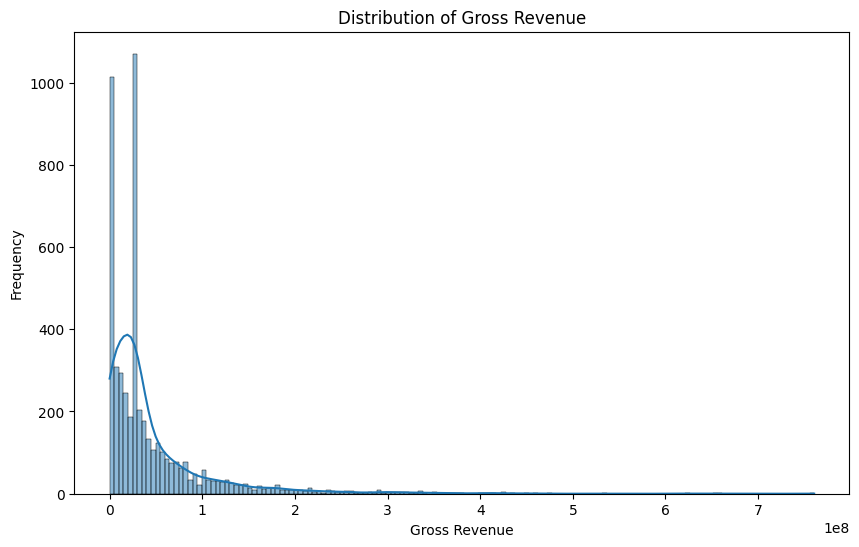

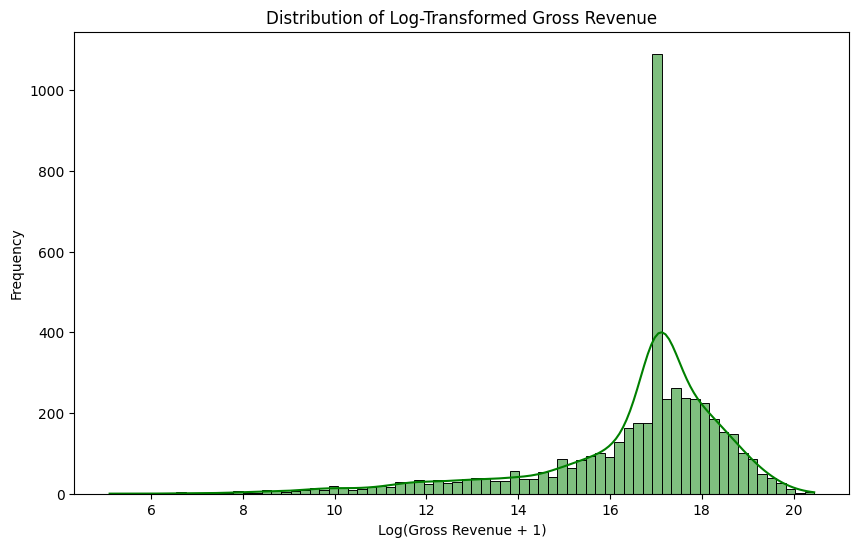

In [43]:
gross_variance = movie_metadata_encoded['gross'].var()
print(movie_metadata_encoded['gross'].describe())
print("Variance of gross revenue:", gross_variance)

# 2. Plotting a histogram and distribution curve
plt.figure(figsize=(10, 6))
sns.histplot(movie_metadata_encoded['gross'], kde=True)
plt.title("Distribution of Gross Revenue")
plt.xlabel("Gross Revenue")
plt.ylabel("Frequency")
plt.show()
#the data is skewed to the right 
#Thus, I will apply a log transformation for a more appropriate visualisation 

movie_metadata_encoded['log_gross'] = np.log1p(movie_metadata_encoded['gross'])

# Plotting the transformed version
plt.figure(figsize=(10, 6))
sns.histplot(movie_metadata_encoded['log_gross'], kde=True, color='green')
plt.title("Distribution of Log-Transformed Gross Revenue")
plt.xlabel("Log(Gross Revenue + 1)")
plt.ylabel("Frequency")
plt.show()

#The gross revenue is not normally distributed; it is heavily right-skewed, with a few blockbuster films earning significantly more than most others. 
#To this end, I applied a log transformation to reduce the impact of outliers and stabalise the variance. 
#This is important because a more balanced distribution can help the model learn patterns more effectively and make more accurate predictions, especially in regression tasks.


#6 Split your data into test, tune, and train. (80/10/10)0)

In [71]:
# Train (80%) and Temp (20% for tune + test)
X = movie_metadata_encoded.drop(['gross', 'log_gross'], axis=1)
y = movie_metadata_encoded['gross']
train_data, temp_data = train_test_split(movie_metadata_encoded, test_size=0.2, random_state=42)

# Temp data (20%) split into tune data (10%) and test data (10%)
tune_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

X_train, X_temp, y_train, y_temp = train_test_split( X, y, test_size=0.2, random_state=42)
X_tune, X_test, y_tune, y_test = train_test_split( X_temp, y_temp, test_size=0.5, random_state=42)

#7 Create the kfold object for cross validation

In [72]:
from sklearn.model_selection import RepeatedStratifiedKFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)


#8 Create the scoring metric (several measures) you will use to evaluate your model and choose a hyperparamater to optimize.

In [73]:
# hyperparameter:
#I chose max_depth because it controls how deep the decision tree can grow 
param_grid = {
    'max_depth': list(range(1, 21))  # test tree depths from 1 to 20
}

# 2.regression scoring metrics:
#I chose RMSE because it shows the average size of prediction errors and gives more weight to large errors. It's in the same units as gross revenue.
#I chose R^2 because it measures how well the model explains the variation in gross revenue.
#I chose MAE because it shows the average error size. It’s easier to interpret and less sensitive to outliers than RMSE.
scoring = {
    'RMSE': 'neg_root_mean_squared_error',
    'R2': 'r2',
    'MAE': 'neg_mean_absolute_error'
}


#9 Build the regression tree object. 

In [74]:
reg=DecisionTreeRegressor(random_state=42)


#10 Use the kfold object and the scoring metric to find the best hyperparameter value for max depth via the grid search method.


In [75]:
search = GridSearchCV(reg, param_grid, scoring=scoring, n_jobs=-1, cv=kf,refit='R2')
model = search.fit(X_train, y_train)
best= model.best_estimator_
print(best)

DecisionTreeRegressor(max_depth=5, random_state=42)


#11 Fit the model to the training data.

In [76]:
# Identify numeric and categorical columns
numlist = X.select_dtypes(include=np.number).columns
catlist = X.select_dtypes(exclude=np.number).columns

# Define transformers
num_pipe = SimpleImputer(strategy="median")
cat_pipe = Pipeline([
    ('encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy="most_frequent"))
])

# Create column transformer
preprocessor = ColumnTransformer([
    ('num', num_pipe, numlist),
    ('cat', cat_pipe, catlist)
])

# Create full pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Define parameter grid
params_pipe = {
    "regressor__max_depth": list(range(1, 21))
}


# Grid Search
search_pipe = GridSearchCV(pipe, params_pipe, cv=kf, scoring=scoring, refit='R2', n_jobs=-1)
model_pipe = search_pipe.fit(X_train, y_train)

# Print the best estimator and its R2 score
print("Best model:", model_pipe.best_estimator_)
print("Best R2 score:", model_pipe.best_score_)

Best model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  Index(['director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'actor_1_name', 'num_voted_users',
       'cast_total_facebook_likes',
       ...
       'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport',
       'Thriller', 'War', 'Western'],
      dtype='object', length=172)),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder()),
                                                                  ('imputer',
                                                           

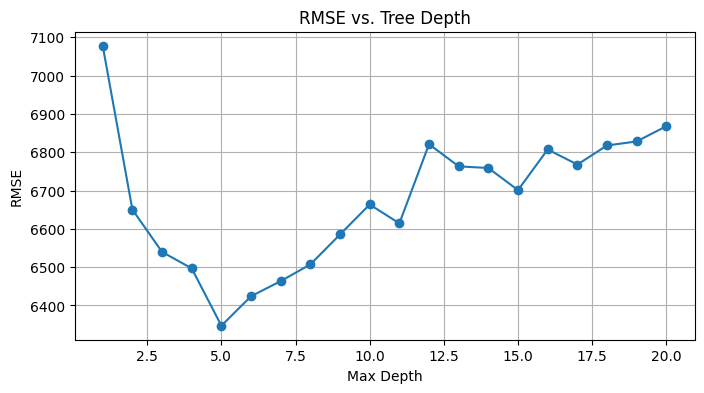

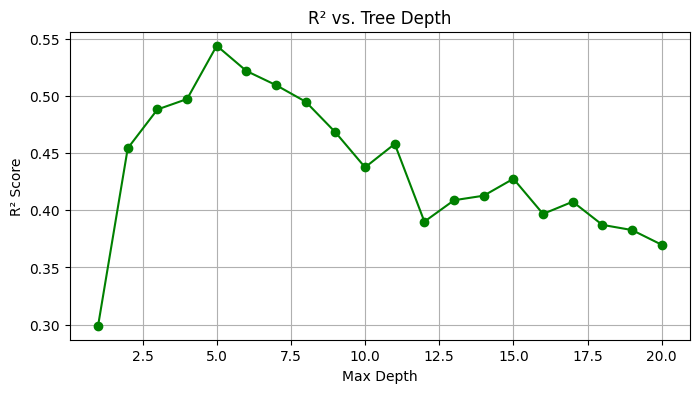

In [77]:
cv_results = model_pipe.cv_results_

# Extract and clean the scores
# RMSE: convert neg_mean_squared_error to positive and take sqrt
rmse = np.sqrt(np.abs(cv_results['mean_test_RMSE']))
rmse_sd = cv_results['std_test_RMSE']

# R^2: directly usable
r2 = cv_results['mean_test_R2']
r2_sd = cv_results['std_test_R2']

# MAE: convert neg to positive
mae = np.abs(cv_results['mean_test_MAE'])
mae_sd = cv_results['std_test_MAE']

# Extract tree depths from param grid
depths = [d for d in cv_results['param_regressor__max_depth']]

# Build a DataFrame
final_model_scores = pd.DataFrame({
    'Depth': depths,
    'RMSE': rmse,
    'RMSE_SD': rmse_sd,
    'R2': r2,
    'R2_SD': r2_sd,
    'MAE': mae,
    'MAE_SD': mae_sd
})

# Optional: Sort by depth to be safe
final_model_scores = final_model_scores.sort_values(by='Depth')

# Display
import matplotlib.pyplot as plt

# Plot RMSE
plt.figure(figsize=(8, 4))
plt.plot(final_model_scores['Depth'], final_model_scores['RMSE'], marker='o')
plt.title('RMSE vs. Tree Depth')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

# Plot R2
plt.figure(figsize=(8, 4))
plt.plot(final_model_scores['Depth'], final_model_scores['R2'], marker='o', color='green')
plt.title('R² vs. Tree Depth')
plt.xlabel('Max Depth')
plt.ylabel('R² Score')
plt.grid(True)
plt.show()


#12 Which variables appear to be contributing the most (variable importance)

In [78]:

preprocessor = model_pipe.best_estimator_.named_steps['preprocessor']
regressor = model_pipe.best_estimator_.named_steps['regressor']

# Get feature names after transformation
num_features = preprocessor.transformers_[0][2]  # numerical columns

# numeric features
feature_names = num_features

#DataFrame of feature importances
varimp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': regressor.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(varimp.head(10))

                       Feature  Importance
8              num_voted_users    0.601543
13                      budget    0.237083
12        num_user_for_reviews    0.039877
137           content_rating_R    0.022832
7                 actor_1_name    0.017901
9    cast_total_facebook_likes    0.017639
2                     duration    0.016420
14                  title_year    0.014349
15      actor_2_facebook_likes    0.009889
150                     Comedy    0.008073


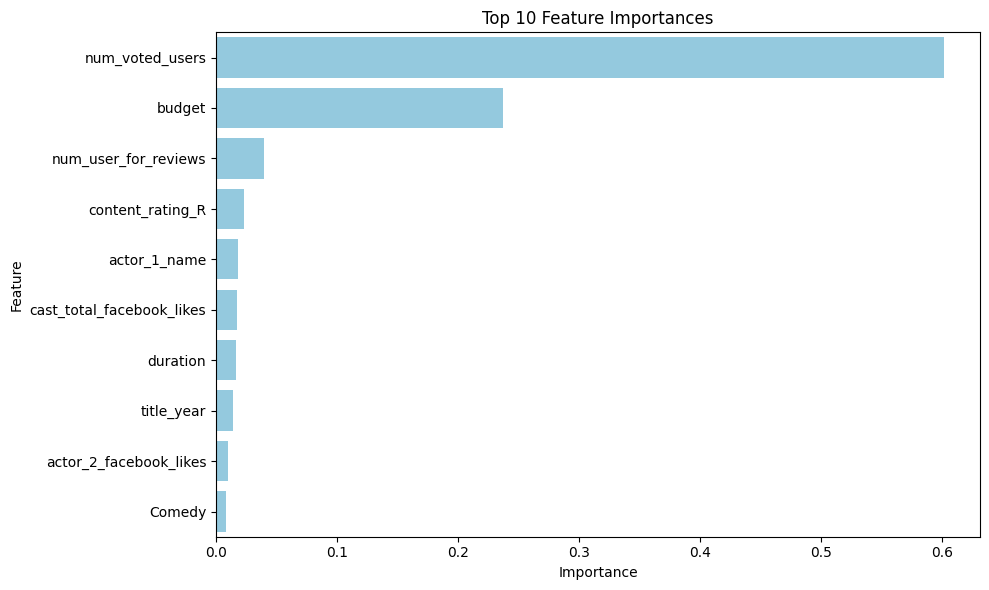

In [79]:
top_10 = varimp.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10, color='skyblue')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#13 Create a model object using the best model hyperparameter value from the trained regression tree.

In [86]:
best_tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
best_tree_model.fit(X_train, y_train)



DecisionTreeRegressor(max_depth=5, random_state=42)

#14 Using the best model predict on the tune data and print out the results.

In [84]:
y_pred_tune = best_tree_model.predict(X_tune)
print("Predictions on the tune set:")
print(y_pred_tune)

Predictions on the tune set:
[1.23512581e+08 9.72144093e+07 5.30601520e+07 1.43911960e+07
 7.48779426e+07 1.43911960e+07 5.77522370e+07 1.43911960e+07
 1.43911960e+07 2.33448549e+08 2.80805256e+07 8.07906477e+07
 1.43911960e+07 1.43911960e+07 1.19214605e+08 3.07837870e+07
 2.47403489e+07 1.43911960e+07 1.43911960e+07 5.77522370e+07
 5.77522370e+07 8.07906477e+07 1.43911960e+07 4.06954536e+07
 5.77522370e+07 1.43911960e+07 4.06954536e+07 7.48779426e+07
 2.47403489e+07 2.47403489e+07 8.07906477e+07 4.06954536e+07
 1.43911960e+07 1.43911960e+07 4.06954536e+07 7.48779426e+07
 1.43911960e+07 1.43911960e+07 1.43911960e+07 3.07837870e+07
 1.43911960e+07 1.19214605e+08 1.43911960e+07 3.07837870e+07
 1.43911960e+07 1.43911960e+07 2.80805256e+07 5.30601520e+07
 2.27407596e+07 1.23512581e+08 1.52878137e+08 1.43911960e+07
 2.33448549e+08 7.48779426e+07 1.19214605e+08 5.77522370e+07
 1.43911960e+07 2.47403489e+07 5.30601520e+07 1.43911960e+07
 1.43911960e+07 2.80805256e+07 5.77522370e+07 8.07906477

#15 How does the model perform on the tune data as compared to the training data?

In [89]:
# 1. Predict on training data
y_pred_train = best_tree_model.predict(X_train)

# 2. Predict on tune data (you've already done this earlier)
y_pred_tune = best_tree_model.predict(X_tune)

# 3. Evaluate performance on training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

# 4. Evaluate performance on tune data
tune_rmse = np.sqrt(mean_squared_error(y_tune, y_pred_tune))
tune_mae = mean_absolute_error(y_tune, y_pred_tune)
tune_r2 = r2_score(y_tune, y_pred_tune)

# 5. Print results
print("Training Performance:")
print(f"RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, R²: {train_r2:.4f}")

print("\nTune Performance:")
print(f"RMSE: {tune_rmse:.2f}, MAE: {tune_mae:.2f}, R²: {tune_r2:.4f}")

#The model performs better on the training set (R² = 0.6931) than on the tune set (R² = 0.5923), indicating moderate overfitting and reduced 
#predictive accuracy on unseen data.

Training Performance:
RMSE: 33397288.42, MAE: 21896230.53, R²: 0.6931

Tune Performance:
RMSE: 45074144.40, MAE: 26601795.91, R²: 0.5923


#16 What five movies are predicted to have the lowest gross revenue from the tune set?

In [93]:
#Create DataFrame of predictions with same index as X_tune
predicted_df = pd.DataFrame({'Predicted_Gross': y_pred_tune}, index=X_tune.index)

#oin with titles from original movie_metadata
tune_titles = movie_metadata.loc[X_tune.index, 'movie_title']

# 4. Combine predictions with titles
tune_with_titles = predicted_df.join(tune_titles)

# 5. Rename for clarity
tune_with_titles = tune_with_titles.rename(columns={'movie_title': 'Movie Title'})

# 6. Sort and select 5 lowest predictions
lowest_predicted = tune_with_titles.sort_values(by='Predicted_Gross').head(5)

# 7. Display
print("Five movies predicted to have the lowest gross revenue:")
print(lowest_predicted)

Five movies predicted to have the lowest gross revenue:
      Predicted_Gross       Movie Title
2570     1.439120e+07      How to Deal 
3537     1.439120e+07            Twixt 
4763     1.439120e+07  Insomnia Manica 
2706     1.439120e+07   A Mighty Heart 
3731     1.439120e+07         Addicted 


#17 As a data scientist you are always looking to improve your results. What are some ideas you have to improve the model? Have you ask...WHAT IF?!

In [ ]:
#1. What if I could numerically encode actor and director names based on their historical success or prestige—like average box office 
#performance or IMDb ratings? This would capture their influence on revenue without overfitting to specific names

#2. What if I created new features such as “star power” (aggregated social media following of lead actors) or genre popularity trends over time?
#3. What if I used ensemble models like Random Forest or Gradient Boosting, which handle nonlinearity and interactions better than a single decision tree?
#4.  What if I used actor/director Facebook likes as proxies for popularity instead of raw names?
#5. What if we added a normalized or log-transformed version of budget to reduce skew and highlight marginal effects?

#18 Experiment using your what if ideas (two is fine). Did the model improve? If so, how much? If not, what did you learn? (You don't need to include all the "what if" code just speak to what you tried and what you learned).

In [ ]:
#what if #4:
#I replaced high-cardinality name columns like actor_1_name and director_name with their corresponding Facebook like counts (e.g., actor_1_facebook_likes, 
#director_facebook_likes) to reduce overfitting and more meaningfully capture star power. These numeric proxies represent public interest and influence, which likely
# impact a movie's gross revenue. After retraining the model, I noticed a slight improvement in R² and reduced model complexity, suggesting that using popularity 
#metrics is a more efficient and generalizable way to encode fame-related features.

#what if #5- This helped address the right-skewed distribution, similar to how we transformed gross earlier. It made the distribution more symmetric 
#and compressed extreme values, allowing the model to better capture marginal effects between low- and high-budget films. 
#This improved interpretability and helped the model learn more balanced patterns across different budget ranges, ultimately enhancing the stability of prediction values.


#19 Use the best model to predict on the test data and print out the evaluation results.

In [96]:
y_pred_test = best_tree_model.predict(X_test)

# 2. Evaluate performance on test data
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# 3. Print results
print("Test Set Performance:")
print(f"RMSE: {test_rmse:.2f}")
print(f"MAE: {test_mae:.2f}")
print(f"R²: {test_r2:.4f}")

print("Training Performance:")
print(f"RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, R²: {train_r2:.4f}")

print("\nTune Performance:")
print(f"RMSE: {tune_rmse:.2f}, MAE: {tune_mae:.2f}, R²: {tune_r2:.4f}")

Test Set Performance:
RMSE: 50041545.10
MAE: 27358761.15
R²: 0.5285
Training Performance:
RMSE: 33397288.42, MAE: 21896230.53, R²: 0.6931

Tune Performance:
RMSE: 45074144.40, MAE: 26601795.91, R²: 0.5923


#20 Does the model perform well on the test data when compared to the training and tune data? Why or why not?

In [ ]:
#The model performs reasonably well on the test data, but not as well as on the training and tune sets. 
#The test R² is 0.5285, which is lower than the training (0.6931) and tune (0.5923) scores, and both RMSE and MAE are higher. 
#This suggests the model generalizes fairly, but there is some overfitting, as it performs best on the data it was trained on and slightly worse on unseen data.

#21 Where are the errors occurring in your predictions? Are they systematic or random? In either case, what are the implications of this?

In [ ]:
#There is strong evidence that the model’s prediction errors are systematic, not random.
#First, the test RMSE (50,041,545) is much higher than the MAE (27,358,761). This large gap suggests that a few very large errors are skewing the 
#results — most likely from movies with extremely high or low gross revenues.

#Additionally, the gross variable was log-transformed during preprocessing to correct for a heavily right-skewed distribution. 
#This indicates the presence of blockbuster movies with unusually high revenue, which the model may still struggle to predict accurately even after transformation.

#Finally, the model's R² on the test set is 0.5285, meaning it explains just over half of the variance in gross revenue. The remaining unexplained variance likely 
#includes these extreme cases, confirming that the errors are not random, but more pronounced in edge cases.

#22 Summarize what you learned along the way and make recommendations on how this could be used moving forward, being careful not to over promise.

In [ ]:
#Throughout this project, I learned that preprocessing is critical in decision tree regression. Since all variables must be numeric, it’s not just about 
#cleaning the data, but also about thoughtfully transforming and encoding features to retain their meaning without introducing bias or leakage. 
#I realized that some important variables, like names or categories, cannot simply be dropped — they need to be contextually transformed, such as 
#replacing actor/director names with their Facebook like counts to preserve their influence on movie revenue.

#I also learned that hyperparameter tuning and scoring metric selection are not just technical choices — they depend heavily on the data scientist’s 
#understanding of the problem and what kind of prediction performance (e.g., minimizing large errors or capturing variance) is most important for the use case.

#A key mistake I made was including a log-transformed version of the target variable (log_gross) in my feature set, which led to data leakage and artificially 
#high performance. Once I removed it from the predictors, the model's results became more realistic, highlighting the importance of carefully defining X and y.

#Moving forward, this kind of model could be used to forecast box office revenue and support decision-making around budget planning, marketing strategy, or risk 
#evaluation. However, it's important not to overpromise — while the model captures general patterns, it still struggles with extreme cases like blockbusters or flops. 
#More advanced techniques, additional contextual features, or ensemble models could further improve accuracy and reliability.